In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import torch, torch.nn as nn
import torchvision

from copy import copy
from IPython import display
from IPython.display import clear_output
from PIL import Image
from skimage import color, transform
from sklearn.metrics import roc_auc_score
from time import time, sleep
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm

In [2]:
device = 'cpu'

In [3]:
fmnist_train_set = torchvision.datasets.FashionMNIST("./data_fmnist", download=True,
                                                     transform=transforms.Compose([transforms.ToTensor()]))
fmnist_test_set = torchvision.datasets.FashionMNIST("./data_fmnist", download=True, train=False,
                                                    transform=transforms.Compose([transforms.ToTensor()]))
fmnist_train_data = DataLoader(fmnist_train_set, batch_size=32)
fmnist_test_data = DataLoader(fmnist_test_set, batch_size=32)

In [4]:
mnist_train_set = torchvision.datasets.MNIST("./data_mnist", download=True,
                                             transform=transforms.Compose([transforms.ToTensor()]))
mnist_test_set = torchvision.datasets.MNIST("./data_mnist", download=True, train=False,
                                            transform=transforms.Compose([transforms.ToTensor()]))
mnist_train_data = DataLoader(mnist_train_set, batch_size=32)
mnist_test_data = DataLoader(mnist_test_set, batch_size=32)

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.block_1_conv = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.block_1_relu = nn.ReLU()
        self.block_1_max_pool = nn.MaxPool2d(kernel_size=2, return_indices=True)

        self.block_2_conv = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.block_2_relu = nn.ReLU()
        self.block_2_max_pool = nn.MaxPool2d(kernel_size=2, return_indices=True)
        self.block_2_batch_norm = nn.BatchNorm2d(num_features=16)

        self.block_3_max_unpool = nn.MaxUnpool2d(kernel_size=2)
        self.block_3_relu = nn.ReLU()
        self.block_3_deconv = nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.block_3_batch_norm = nn.BatchNorm2d(num_features=32)

        self.block_4_max_unpool = nn.MaxUnpool2d(kernel_size=2)
        self.block_4_relu = nn.ReLU()
        self.block_4_deconv = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.block_1_conv(x)
        x = self.block_1_relu(x)
        x, ind_1 = self.block_1_max_pool(x)

        x = self.block_2_conv(x)
        x = self.block_2_relu(x)
        x, ind_2 = self.block_2_max_pool(x)
        x = self.block_2_batch_norm(x)

        x = self.block_3_max_unpool(x, ind_2)
        x = self.block_3_relu(x)
        x = self.block_3_deconv(x)
        x = self.block_3_batch_norm(x)

        x = self.block_4_max_unpool(x, ind_1)
        x = self.block_4_relu(x)
        x = self.block_4_deconv(x)
        return x

In [6]:
def validate(autoencoder, data):
    autoencoder.eval()
    total_img = 0
    loss = 0
    for images, _ in tqdm(data):
        with torch.no_grad():
            # Transfering images and labels to GPU if available
            images = images.to(device)
            images = images.view(-1, 1, 28, 28)
            total_img += len(images)
            # Forward pass
            loss += torch.nn.functional.mse_loss(images, autoencoder(images)).item()
    return round(loss / total_img, 5)

In [7]:
def plot_results(train_log, val_log, test_log):
    clear_output(wait=True)
    print("Epoch", len(train_log))
    print("Train loss:\t", train_log[-1])
    print("Val loss:\t", val_log[-1])
    print("Test loss:\t", test_log[-1])

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(train_log, label='train loss', c='b')
    ax1.plot(val_log, label='val loss', c='r')
    ax1.grid()
    ax1.legend(loc='best')

    ax2.plot(test_log, label='test_loss', c='g')
    ax2.legend(loc='best')
    ax2.grid()
    plt.show()

In [8]:
def cross_entroy_with_logits(y_pred_teacher, y_pred_student):
    return -torch.sum(torch.exp(y_pred_teacher) * y_pred_student, dim=1).mean()

In [9]:
def forward_kl(y_pred_student, y_pred_teacher):
    return torch.sum(torch.exp(y_pred_teacher) * (y_pred_teacher - y_pred_student))

In [10]:
def reverse_kl(y_pred_student, y_pred_teacher):
    return torch.sum(torch.exp(y_pred_student) * (y_pred_student - y_pred_teacher))

In [11]:
def symmetrized_kl(y_pred_student, y_pred_teacher):
    return forward_kl(y_pred_student, y_pred_teacher) + revrse_kl(y_pred_student, y_pred_teacher)

In [12]:
def train(autoencoder, optimizer, train_log, val_log, test_log, num_epochs=30, batch_size=32):
    for epoch in range(num_epochs):
        autoencoder.train()
        for images, _ in tqdm(fmnist_train_data):
            # Transfering images and labels to GPU if available
            images = images.to(device)
            images = images.view(-1, 1, 28, 28)
            # Forward pass
            images_pred = autoencoder(images.to(device))
            loss = torch.nn.functional.mse_loss(images, images_pred)
            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_log.append(validate(autoencoder, fmnist_train_data))
        val_log.append(validate(autoencoder, fmnist_test_data))
        test_log.append(validate(autoencoder, mnist_train_data))
        plot_results(train_log, val_log, test_log)

In [13]:
train_log = []
val_log = []
test_log = []

In [14]:
autoencoder = Autoencoder().to(device)

In [15]:
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0001)

Epoch 50
Train loss:	 9e-05
Val loss:	 9e-05
Test loss:	 0.00012


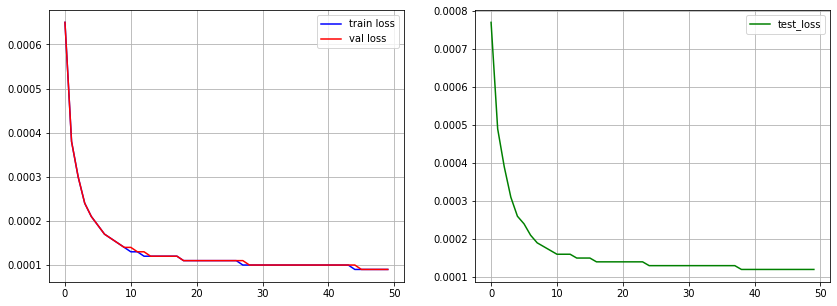

CPU times: user 5h 49min 41s, sys: 34min 8s, total: 6h 23min 50s
Wall time: 3h 28min 15s


In [16]:
%%time
train(autoencoder, optimizer, train_log, val_log, test_log, batch_size=32, num_epochs=50)

In [18]:
def get_prediction_errors(autoencoder, data):
    autoencoder.eval()
    total_img = 0
    loss = []
    for images, _ in tqdm(data):
        with torch.no_grad():
            # Transfering images and labels to GPU if available
            images = images.to(device)
            images = images.view(-1, 1, 28, 28)
            total_img += len(images)
            # Forward pass
            loss.append(torch.nn.functional.mse_loss(images, autoencoder(images)).item())
    return loss

In [19]:
fmnist_prediction_errors = get_prediction_errors(autoencoder, DataLoader(fmnist_train_set, batch_size=1))
mnist_prediction_errors = get_prediction_errors(autoencoder, DataLoader(mnist_train_set, batch_size=1))

In [24]:
y_true = [1] * len(fmnist_prediction_errors) + [0] * len(mnist_prediction_errors)
y_pred = mnist_prediction_errors + fmnist_prediction_errors

In [25]:
roc_auc_score(y_true, y_pred)

0.7077999519444444